In [197]:
import numpy as np
import pandas as pd
import yfinance as yf
from full_fred.fred import Fred
from functools import reduce
import statsmodels.tsa.stattools as ss 
from statsmodels.tsa.api import VAR
import seaborn as sns
import matplotlib.pyplot as plt

In [198]:
fred = Fred('API_key.txt')

#### Exchange Rates and Commodity prices 

1. Canada -> WTI Crude 
2. Norway -> Brent Crude 
3. Australia -> Gold
4. New Zealand -> Lamp 
5. South Africa -> Gold
6. Brazil -> Brent Crude




In [317]:
exchange_list = {'DEXCAUS':'CAD',
                 'DEXNOUS':'NOK',
                 'DEXSFUS':'ZAR',
                 'DEXBZUS':'BRL'}

ex_USD_denom = {'DEXUSNZ':'NZD',
                'DEXUSAL':'AUD'}

commodities_fred = {'PLAMBUSDM':'Lamb',
                    'POILWTIUSDM':'WTI Crude',
                    'POILBREUSDM':'Brent Crude',
                    'PCOPPUSDM':'Copper'} 

In [318]:
gold = yf.download('GC=F', period="max",interval='1mo').reset_index().rename(
        columns={'Date':'date','Adj Close':'Gold'})[['date','Gold']]
gold['date'] = pd.to_datetime(gold['date']) 

[*********************100%***********************]  1 of 1 completed


In [319]:
ex_rate = []

for i in exchange_list.keys():
    dd = fred.get_series_df(i).rename(
             columns={'value':exchange_list[f'{i}']})[
             ['date',exchange_list[f'{i}']]].replace('.',np.nan)
    dd[exchange_list[f'{i}']] = dd[exchange_list[f'{i}']].astype(float)
    dd['date'] = pd.to_datetime(dd['date'])
    dd = dd.dropna() 
    dd[exchange_list[f'{i}']] = 1.0/dd[exchange_list[f'{i}']]
    ex_rate.append(dd)

for i in ex_USD_denom.keys():
    ff = fred.get_series_df(i).rename(
             columns={'value':ex_USD_denom[f'{i}']})[
             ['date',ex_USD_denom[f'{i}']]].replace('.',np.nan)
    ff[ex_USD_denom[f'{i}']] = ff[ex_USD_denom[f'{i}']].astype(float)
    ff['date'] = pd.to_datetime(ff['date'])
    ff = ff.dropna() 
    ex_rate.append(ff)

ex_rate_final = reduce(lambda left,right: 
                    pd.merge(left,right,on=['date'],), 
                    ex_rate)


In [320]:
comm = []
for i in commodities_fred.keys():
    cc = fred.get_series_df(i).rename(
             columns={'value':commodities_fred[f'{i}']})[
             ['date',commodities_fred[f'{i}']]].replace('.',np.nan)
    cc[commodities_fred[f'{i}']] = cc[commodities_fred[f'{i}']].astype(float)
    cc['date'] = pd.to_datetime(cc['date'])
    cc = cc.dropna() 
    comm.append(cc)
comm_final = reduce(lambda left,right: 
                    pd.merge(left,right,on=['date'],), 
                    comm)


#### Pairs

In [321]:
# Canadian Dollar / WTI CRUDE Pair
cad_wti_crude_pair = comm_final[['date','WTI Crude']
                     ].merge(ex_rate_final[['date','CAD']])
cad_wti_crude_pair[['WTI Crude','CAD']] = 100*(cad_wti_crude_pair[
                             ['WTI Crude','CAD']].pct_change())
cad_wti_crude_pair = cad_wti_crude_pair.dropna()


# Norwegian Krone / Brent Crude Pair
nok_brent_crude_pair = comm_final[['date','Brent Crude']
                     ].merge(ex_rate_final[['date','NOK']])
nok_brent_crude_pair[['Brent Crude','NOK']] = 100*(nok_brent_crude_pair[
                        ['Brent Crude','NOK']].pct_change())
nok_brent_crude_pair = nok_brent_crude_pair.dropna()



# New Zealand Dollar / Lamb Pair
nzd_lamb_pair = comm_final[['date','Lamb']
                     ].merge(ex_rate_final[['date','NZD']])
nzd_lamb_pair[['Lamb','NZD']] = 100*(nzd_lamb_pair[
                       ['Lamb','NZD']].pct_change())
nzd_lamb_pair = nzd_lamb_pair.dropna()


# Brazilian Real / Brent Crude Pair
bzn_brent_pair = comm_final[['date','Brent Crude']
                     ].merge(ex_rate_final[['date','BRL']])
bzn_brent_pair[['Brent Crude','BRL']] = 100*(bzn_brent_pair[
                       ['Brent Crude','BRL']].pct_change())
bzn_brent_pair = bzn_brent_pair.dropna()


# Australian Dollar / Gold
aum_gold_pair = gold.merge(ex_rate_final[['date','AUD']])
aum_gold_pair[['Gold','AUD']] = 100*(aum_gold_pair[
                       ['Gold','AUD']].pct_change())
aum_gold_pair = aum_gold_pair.dropna()


# South African Rand / Gold
sar_gold_pair = gold.merge(ex_rate_final[['date','ZAR']])
sar_gold_pair[['Gold','ZAR']] = 100*(sar_gold_pair[
                       ['Gold','ZAR']].pct_change())
sar_gold_pair = sar_gold_pair.dropna()


#### Stationarity of Pairs

In [322]:
def ADF_test(df):
    adf = pd.DataFrame([[
               ss.adfuller(df[i])[0],
               ss.adfuller(df[i])[1],i] 
               for i in df.columns[1:]], 
               columns=['ADF Statistic:',
                        'p-value',
                        'Indicator']).round(3)
    return adf

In [323]:
ADF_test(cad_wti_crude_pair)

,ADF Statistic:,p-value,Indicator
0,-10.946,0.0,WTI Crude
1,-11.168,0.0,CAD


In [324]:
ADF_test(nok_brent_crude_pair)

,ADF Statistic:,p-value,Indicator
0,-10.793,0.0,Brent Crude
1,-13.649,0.0,NOK


In [325]:
ADF_test(nzd_lamb_pair)

,ADF Statistic:,p-value,Indicator
0,-5.522,0.0,Lamb
1,-13.251,0.0,NZD


In [326]:
ADF_test(bzn_brent_pair)

,ADF Statistic:,p-value,Indicator
0,-10.793,0.0,Brent Crude
1,-10.391,0.0,BRL


In [327]:
ADF_test(aum_gold_pair)

,ADF Statistic:,p-value,Indicator
0,-15.813,0.0,Gold
1,-11.938,0.0,AUD


In [328]:
ADF_test(sar_gold_pair) 

,ADF Statistic:,p-value,Indicator
0,-15.813,0.0,Gold
1,-9.720,0.0,ZAR


### Exchange Rates explaining Commodity prices

In [358]:
def get_responses(df):
    col = df.columns[1:]
    model = VAR(df[col])
    results = model.fit(maxlags=11)
    _irf = results.irf(21)
    return pd.DataFrame([_irf.orth_cum_effects[k][0] for 
    #return pd.DataFrame([_irf.cum_effects[k][0] for 
            k in range(21)]).rename(columns={
            0:f'{col[0]}-{col[0]}',1:f'{col[1]}-{col[0]}'})

In [359]:
final_responses_com_ex =  pd.concat([get_responses(cad_wti_crude_pair).iloc[:, 1],
                                     get_responses(nok_brent_crude_pair).iloc[:, 1],
                                     get_responses(nzd_lamb_pair).iloc[:, 1],
                                     get_responses(bzn_brent_pair).iloc[:, 1],
                                     get_responses(aum_gold_pair).iloc[:, 1],
                                     get_responses(sar_gold_pair).iloc[:, 1]],axis=1)

c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was

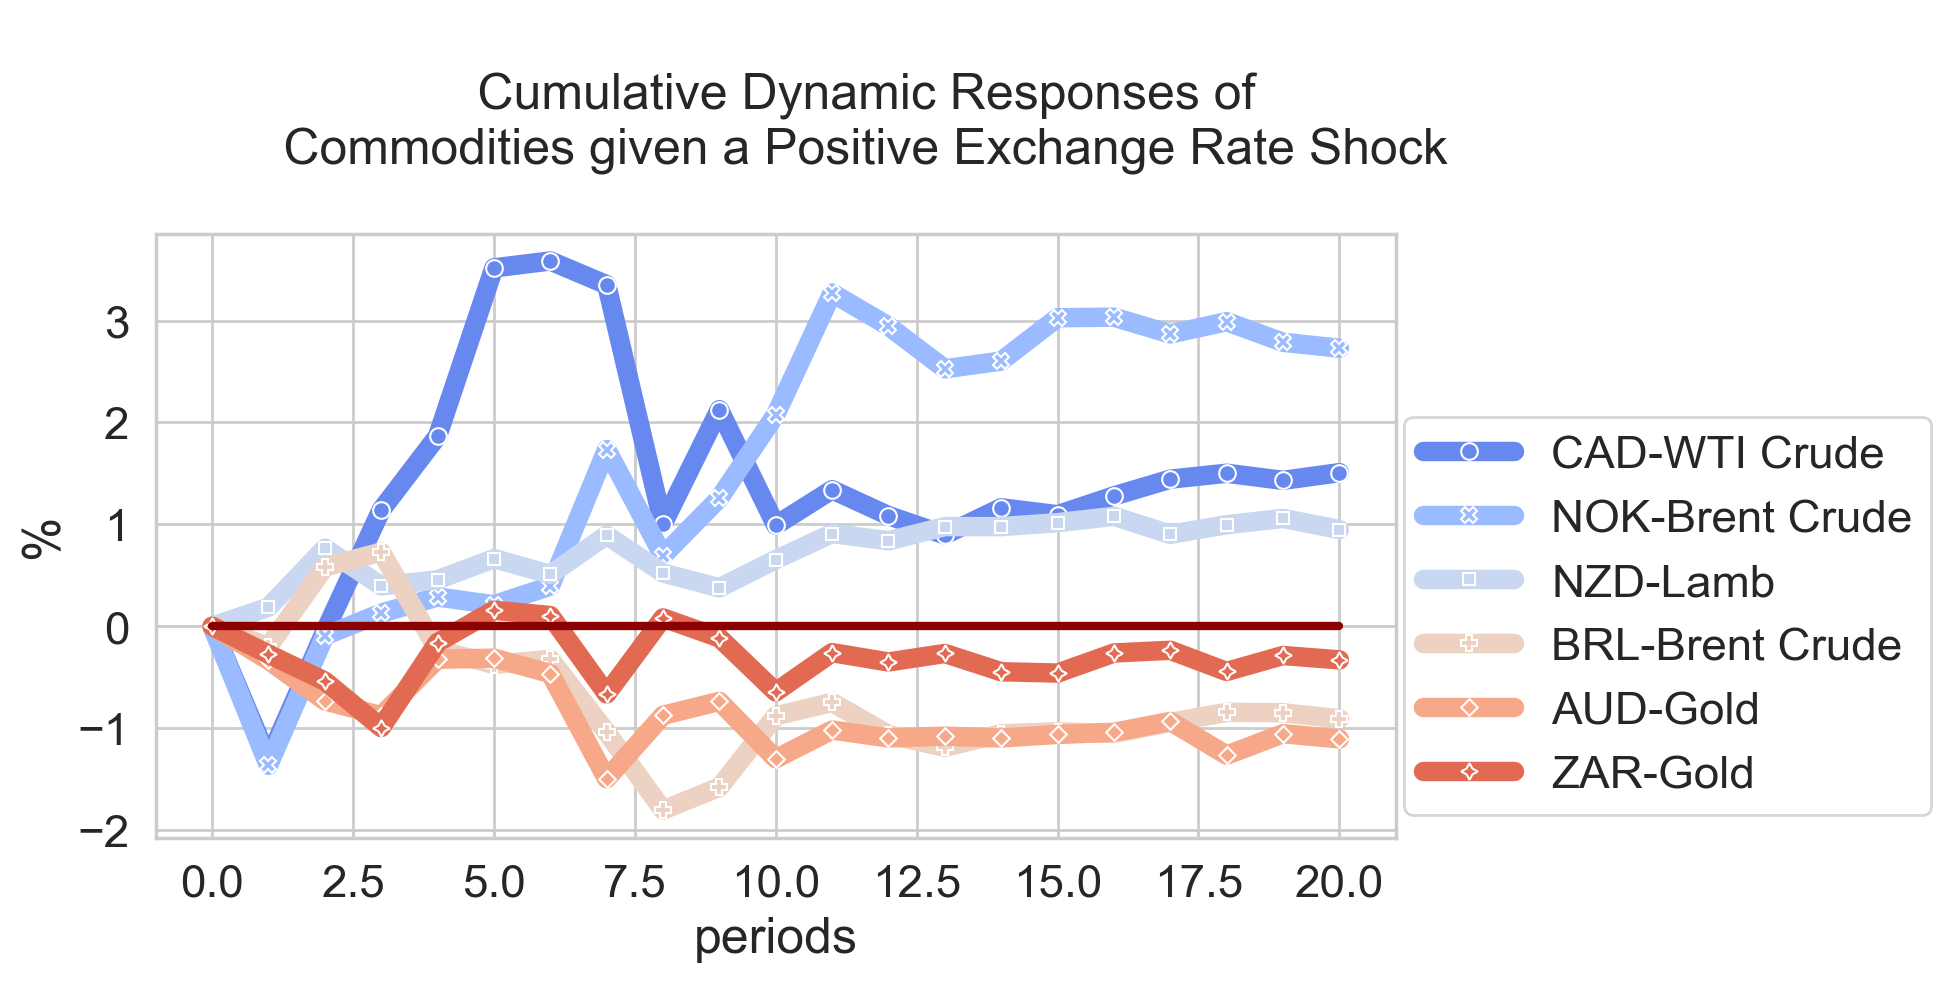

In [382]:
plt.figure(figsize=(8,4),dpi=200)
sns.set_theme(style="whitegrid",font_scale=1.5)
sns.lineplot(data=final_responses_com_ex,palette='coolwarm',linewidth = 7,
             markers=True,dashes=False).set(title=f"""
             Cumulative Dynamic Responses of
             Commodities given a Positive Exchange Rate Shock
             """,xlabel='periods',ylabel='%')
sns.lineplot(data=[0]*21, color='darkred', linewidth=3)
plt.legend(labels=final_responses_com_ex.columns.tolist(),
               bbox_to_anchor=(1.45,0), loc='lower right') 


In [373]:
def get_fevd(tmp_list):
    
    commodity_fevd = []
    exchange_fevd = []
    
    for df in tmp_list:

        col = df.columns[1:]
        model = VAR(df[col])
        results = model.fit(maxlags=11)
        fevd = results.fevd(21)
        c_fevd = [fevd.decomp[0][k][0] for k in range(21)]
        e_fevd = [fevd.decomp[0][k][1] for k in range(21)] 
        commodity_fevd.append(c_fevd)
        exchange_fevd.append(e_fevd)
        
        
    fevd_df = pd.DataFrame([pd.DataFrame(commodity_fevd).mean().to_list(),
                        pd.DataFrame(exchange_fevd).mean().to_list()],).T.rename(
                        columns={0:'Commodity Price',1:'Exchange Rate'}
                        )
    return fevd_df       


In [377]:
pairs_list = [cad_wti_crude_pair, nok_brent_crude_pair, 
              nzd_lamb_pair, bzn_brent_pair, 
              aum_gold_pair, sar_gold_pair]



In [380]:
def graph_FEVD(p_list):
    df_fevd  = get_fevd(p_list)
    plt.figure(dpi=200)
    sns.set_theme(style="white")

    ax1 = df_fevd.plot(kind='bar', stacked=True, figsize=(12,6),
         fontsize=20, legend=True, colormap='coolwarm')
    ax1.legend(loc=2,fontsize=20)
    ax1.set_xlabel('periods',fontdict={'fontsize':20})
    ax1.set_title(f'FEVD of Commodities',pad=10, fontdict={'fontsize':30})
    ax1.set_xticklabels(df_fevd.index, rotation=360)
    ax1.legend(loc=3,fontsize=20)


c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was

<Figure size 1200x800 with 0 Axes>

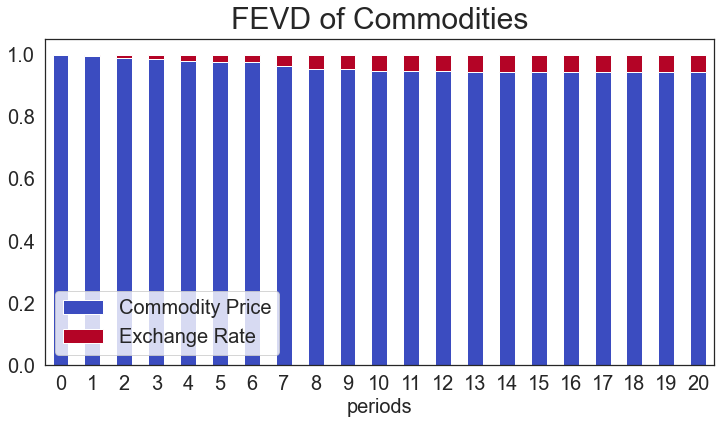

In [381]:
graph_FEVD(pairs_list)

### Commodity Prices explaining Exchange Rates

In [362]:
def get_responses_reverse(df):
    col = df.columns[1:][::-1]
    model = VAR(df[col])
    results = model.fit(maxlags=11)
    _irf = results.irf(21)
    return pd.DataFrame([_irf.orth_cum_effects[k][0] for 
    #return pd.DataFrame([_irf.cum_effects[k][0] for 
            k in range(21)]).rename(columns={
            0:f'{col[0]}-{col[0]}',1:f'{col[1]}-{col[0]}'})

In [363]:
final_responses_ex_com =  pd.concat([get_responses_reverse(cad_wti_crude_pair).iloc[:, 1],
                                     get_responses_reverse(nok_brent_crude_pair).iloc[:, 1],
                                     get_responses_reverse(nzd_lamb_pair).iloc[:, 1],
                                     get_responses_reverse(bzn_brent_pair).iloc[:, 1],
                                     get_responses_reverse(aum_gold_pair).iloc[:, 1],
                                     get_responses_reverse(sar_gold_pair).iloc[:, 1]],axis=1)

c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was

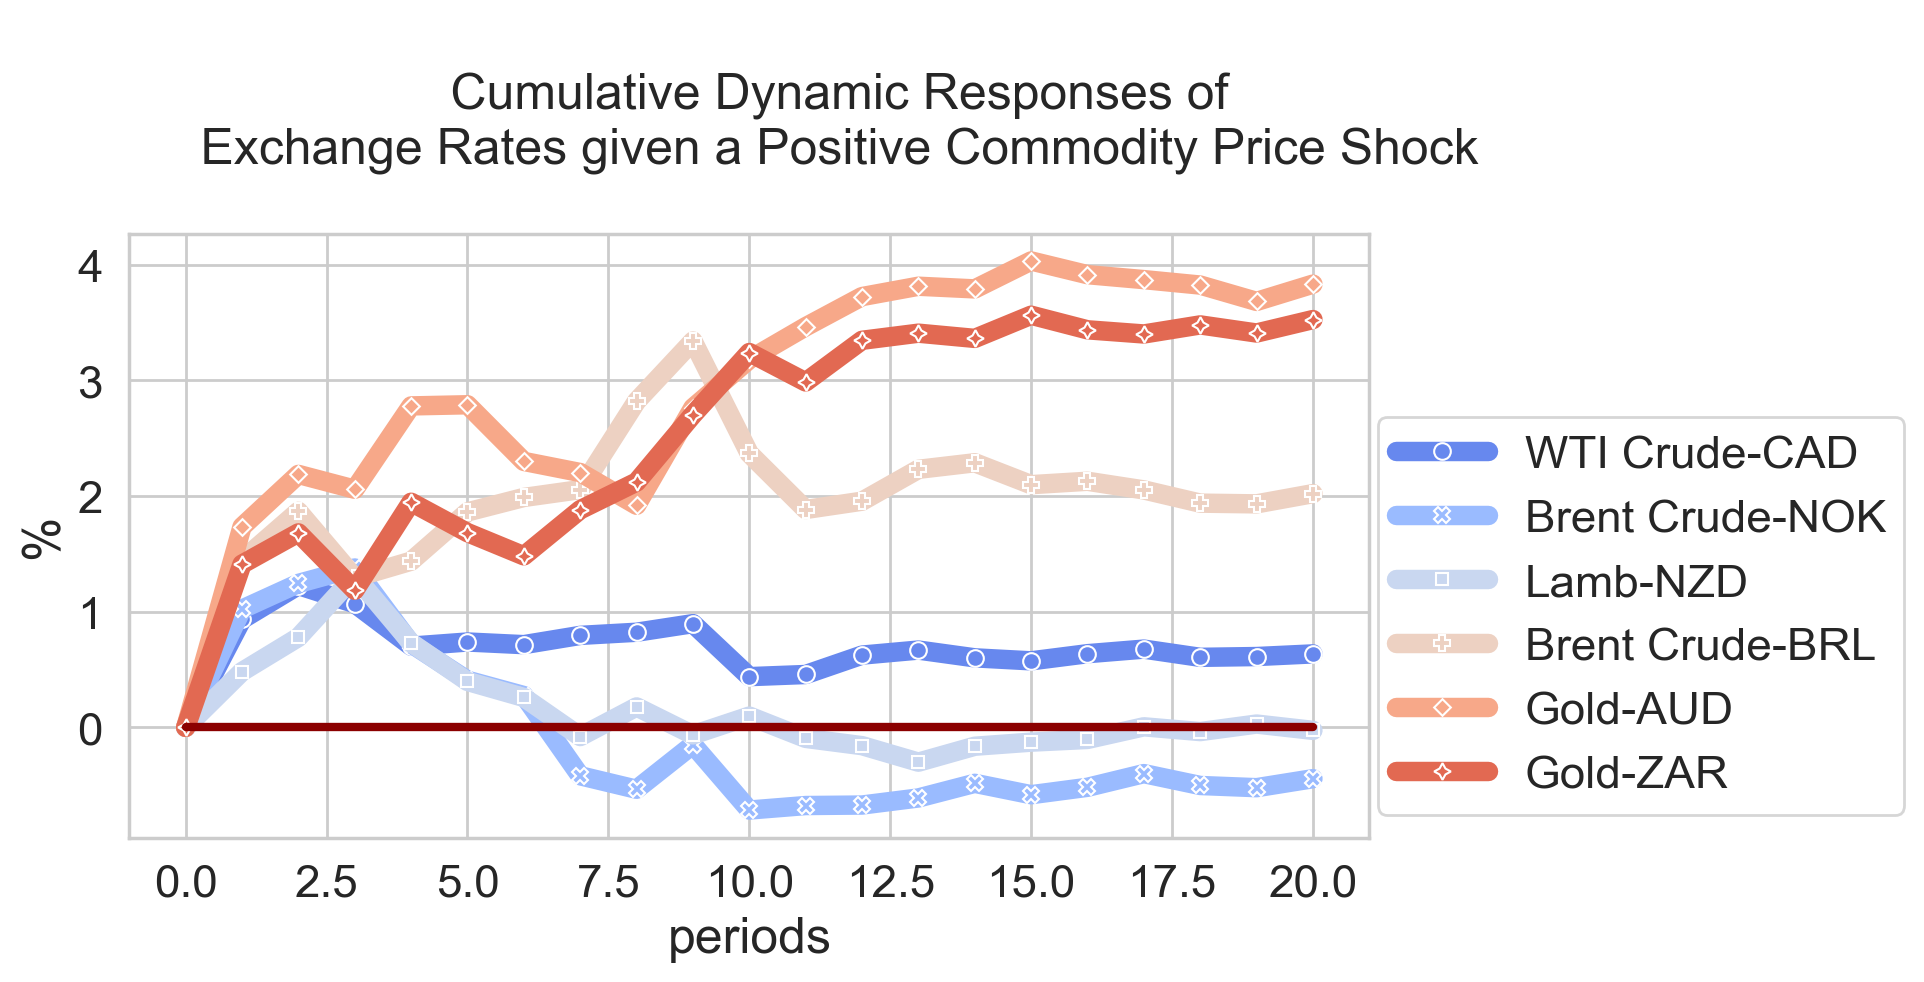

In [365]:
plt.figure(figsize=(8,4),dpi=200)
sns.set_theme(style="whitegrid",font_scale=1.5)
sns.lineplot(data=final_responses_ex_com,palette='coolwarm',linewidth = 7,
             markers=True,dashes=False).set(title=f"""
             Cumulative Dynamic Responses of
             Exchange Rates given a Positive Commodity Price Shock
             """,xlabel='periods',ylabel='%')
sns.lineplot(data=[0]*21, color='darkred', linewidth=3)
plt.legend(labels=final_responses_ex_com.columns.tolist(),
               bbox_to_anchor=(1.45,0), loc='lower right') 


In [392]:
def get_fevd_reverse(tmp_list):
    
    commodity_fevd = []
    exchange_fevd = []
    
    for df in tmp_list:

        col = df.columns[1:][::-1]
        model = VAR(df[col])
        results = model.fit(maxlags=11)
        fevd = results.fevd(21)
        e_fevd = [fevd.decomp[0][k][0] for k in range(21)]
        c_fevd = [fevd.decomp[0][k][1] for k in range(21)] 
        commodity_fevd.append(c_fevd)
        exchange_fevd.append(e_fevd)
        
        
    fevd_df = pd.DataFrame([pd.DataFrame(exchange_fevd).mean().to_list(),
                        pd.DataFrame(commodity_fevd).mean().to_list()],).T.rename(
                        columns={0:'Exchange Rate',1:'Commodity Price'}
                        )
    return fevd_df       


In [393]:
def graph_FEVD_rev(p_list):
    df_fevd  = get_fevd_reverse(p_list)
    plt.figure(dpi=200)
    sns.set_theme(style="white")

    ax1 = df_fevd.plot(kind='bar', stacked=True, figsize=(12,6),
         fontsize=20, legend=True, colormap='coolwarm')
    ax1.legend(loc=2,fontsize=20)
    ax1.set_xlabel('periods',fontdict={'fontsize':20})
    ax1.set_title(f'FEVD of Exchange Rates',pad=10, fontdict={'fontsize':30})
    ax1.set_xticklabels(df_fevd.index, rotation=360)
    ax1.legend(loc=3,fontsize=20)


c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Panagiotis Bouras\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was

<Figure size 1200x800 with 0 Axes>

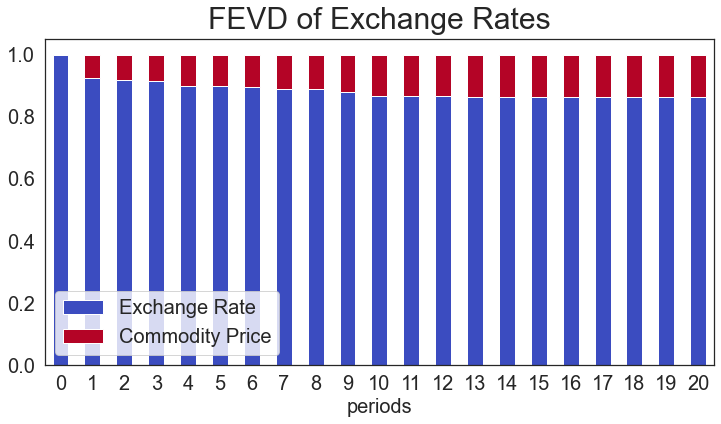

In [394]:
graph_FEVD_rev(pairs_list)